## Code for paper: 'Momentum trading and machine learning within the pharmaceutical sector'

by Tobias Dines Schlünssen & Conrad Frederik Kromann for the seminar "Econometric models in financial applications" by Mads Thorndahl and Frederik Findsen

### Descriptive statistics for the 15 chosen pharmaceutical stocks

In [55]:
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK','JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']

def load_one(ticker):
    path = os.path.join(DATA_DIR, f"{ticker}.csv")
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date")
    
    if "Close" not in df.columns:
        raise ValueError(f"{ticker}.csv missing 'Close' column")
    df["Adj Close"] = df["Close"]
    df["ret"] = df["Adj Close"].pct_change()
    df["Ticker"] = ticker

    mcap_col = next((col for col in df.columns if col.lower() in ["marketcap", "mcap", "market_cap"]), None)
    if mcap_col:
        latest_mcap = df[mcap_col].dropna().iloc[-1]
    else:
        latest_mcap = np.nan

    return df[["Date","Ticker","ret"]], latest_mcap

rets_list = []
market_caps = {}

for t in TICKERS:
    df, mcap = load_one(t)
    rets_list.append(df)
    market_caps[t] = mcap

rets = pd.concat(rets_list, ignore_index=True)
daily_ret = rets.pivot(index="Date", columns="Ticker", values="ret").dropna()

daily_pct_change= daily_ret*100

stats = daily_pct_change.describe().T.rename(
    columns={"count":"Obs","mean":"Mean","std":"σ","min":"Min","max":"Max"}
)[["Obs","Mean","σ","Min","Max"]].round(3)

unit_root_results = {}
for ticker in daily_pct_change.columns:
    try:
        adf_stat, pval, *_ = adfuller(daily_pct_change[ticker].dropna(), autolag='AIC')
        stars = "***" if pval < 0.01 else "**" if pval < 0.05 else "*" if pval < 0.1 else ""
        unit_root_results[ticker] = f"{adf_stat:.2f}{stars}"
    except Exception as e:
        unit_root_results[ticker] = np.nan

stats["Unit root"] = stats.index.map(unit_root_results)

stats["Mcap"] = stats.index.map(market_caps)

stats = stats[["Obs","Mean","σ","Min","Max","Unit root","Mcap"]]
stats = stats.sort_values(by="Mcap", ascending=False)

styled = (
    stats.style
    .format({
        "Mcap": "{:,.0f}",
        "Mean": "{:.2f}",
        "σ": "{:.2f}",
        "Min": "{:.2f}",
        "Max": "{:.2f}"
    })
  
    .set_table_styles([
        {"selector": "caption", "props": [("font-size", "13px"), ("font-weight", "bold"), ("text-align", "center")]}
    ])
)

display(styled)


,Obs,Mean,σ,Min,Max,Unit root,Mcap
Ticker,,,,,,,
LLY,2515.000000,0.11,1.76,-10.52,15.68,-16.44***,"692,064,617,948"
JNJ,2515.000000,0.02,1.14,-10.04,8.00,-16.32***,"348,293,955,909"
ABBV,2515.000000,0.05,1.69,-16.25,13.77,-12.26***,"313,917,396,167"
NVO,2515.000000,0.07,1.77,-17.83,17.23,-51.94***,"289,763,351,293"
MRK,2515.000000,0.03,1.36,-9.86,10.41,-16.97***,"248,479,482,215"
AZN,2515.000000,0.04,1.55,-14.91,9.29,-16.91***,"203,146,007,969"
RHHBY,2515.000000,0.01,1.35,-9.10,13.01,-17.70***,"192,433,292,928"
NVS,2515.000000,0.01,1.21,-9.82,8.00,-18.31***,"188,377,868,998"
PFE,2515.000000,0.01,1.47,-7.74,10.86,-11.03***,"150,837,658,669"


### Returns of the chosen 15 pharmaceutical stocks

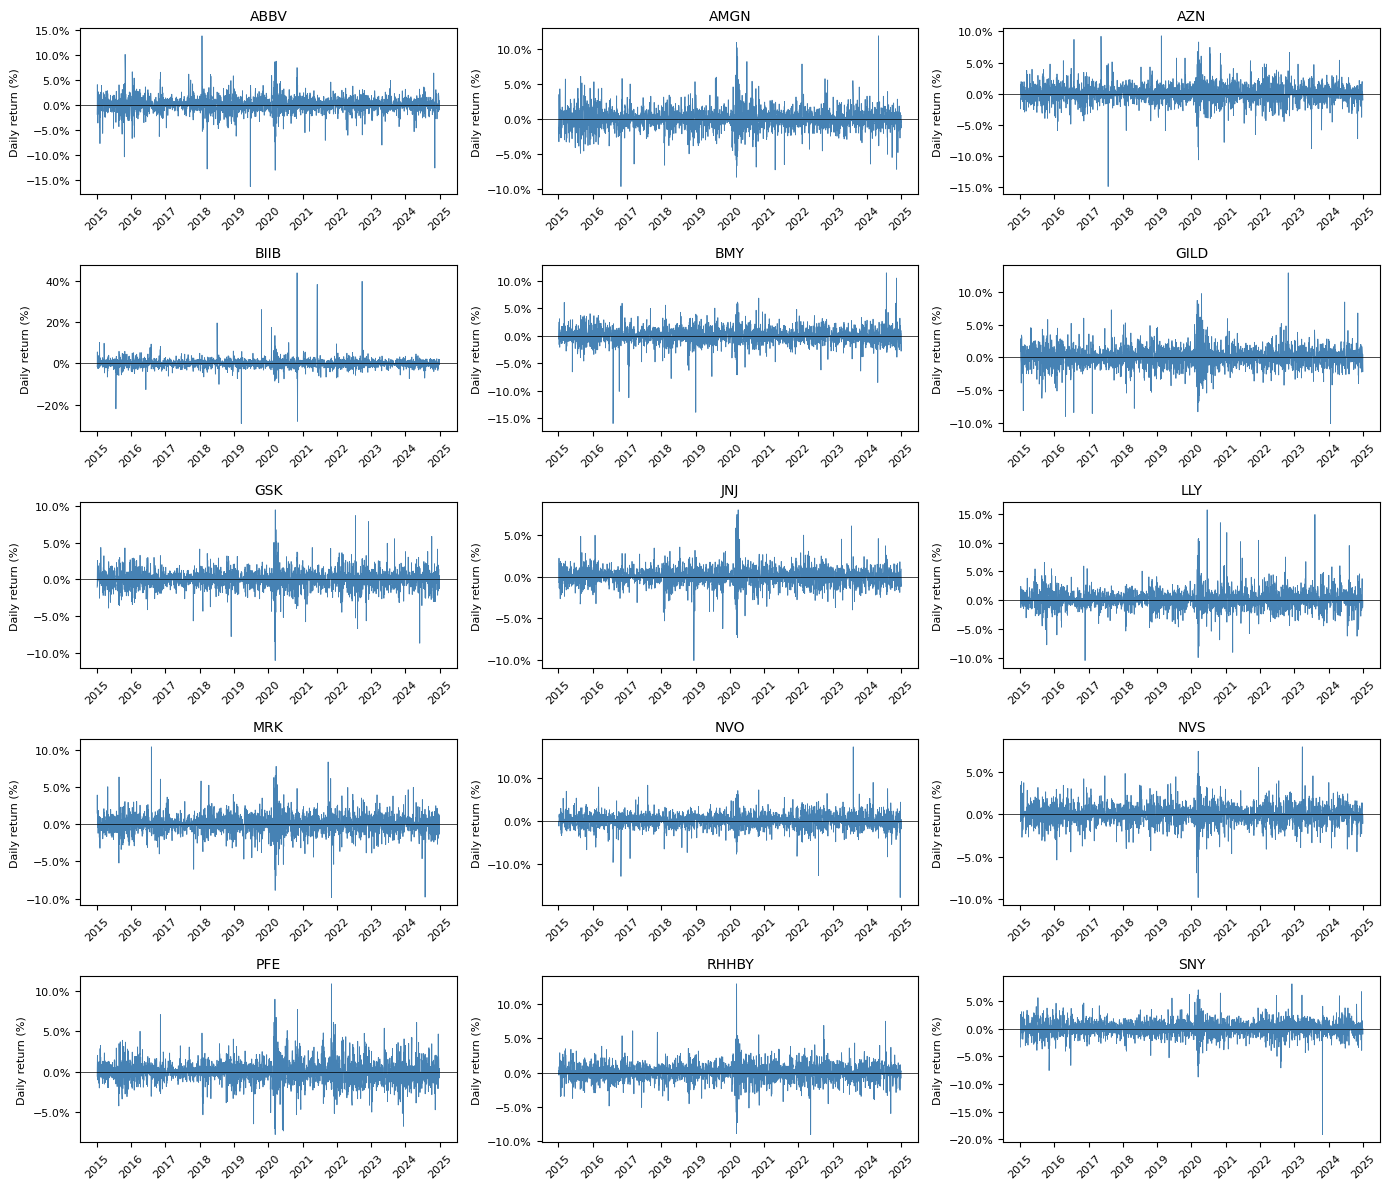

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK', 'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']

def list_tickers(path):
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Data directory not found: {path}")
    return sorted(os.path.splitext(f)[0] for f in os.listdir(path) if f.lower().endswith(".csv"))

def load_one(ticker):
    df = pd.read_csv(os.path.join(DATA_DIR, f"{ticker}.csv"), parse_dates=["Date"]).sort_values("Date")
    if "Close" not in df.columns:
        raise ValueError(f"{ticker}.csv missing 'Close' column")
    df["Adj Close"] = df["Close"]
    df["ret"] = df["Adj Close"].pct_change()
    df["Ticker"] = ticker
    return df[["Date","Ticker","ret"]]

tickers = TICKERS or list_tickers(DATA_DIR)
rets = pd.concat([load_one(t) for t in tickers], ignore_index=True)
daily_ret = rets.pivot(index="Date", columns="Ticker", values="ret").sort_index()

n = len(daily_ret.columns)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 2.5), sharex=False)
axes = np.atleast_1d(axes).ravel()

for i, t in enumerate(daily_ret.columns):
    ax = axes[i]
    ax.plot(daily_ret.index, daily_ret[t]*100, linewidth=0.6, color="steelblue")
    ax.axhline(0, color="black", linewidth=0.5)
    ax.set_title(t, fontsize=10)
    ax.set_ylabel("Daily return (%)", fontsize=8)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


### Pure momentum strategy (no adjustments)

Using 15 tickers: ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY']...
3/5  σ=1.9355  Profit=53.52%  Weekly=0.11%
5/5  σ=2.0626  Profit=161.14%  Weekly=0.22%
15/5  σ=2.0266  Profit=71.35%  Weekly=0.13%
30/5  σ=2.0393  Profit=196.23%  Weekly=0.24%


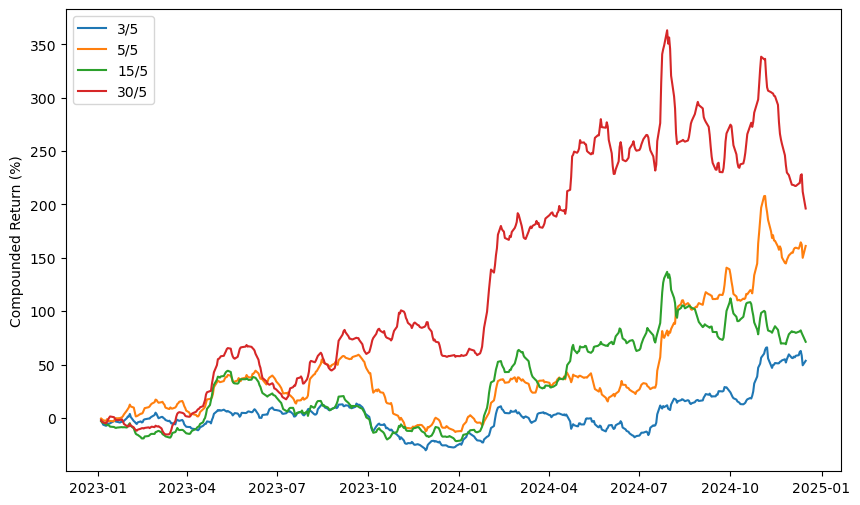

Average 3M T-bill yield over 2023-01-04–2024-12-16: 5.25%


,Obs,Mean (weekly %),Std (weekly %),Sharpe (annual),Ann. Return (%),Ann. Vol (%),RF (annual %)
Strategy,,,,,,,
J=3/5,491,0.106,1.935,0.013,5.437,13.686,5.249
J=5/5,491,0.217,2.063,0.392,11.429,14.585,5.249
J=15/5,491,0.130,2.027,0.097,6.716,14.331,5.249
J=30/5,491,0.242,2.039,0.484,12.844,14.420,5.249


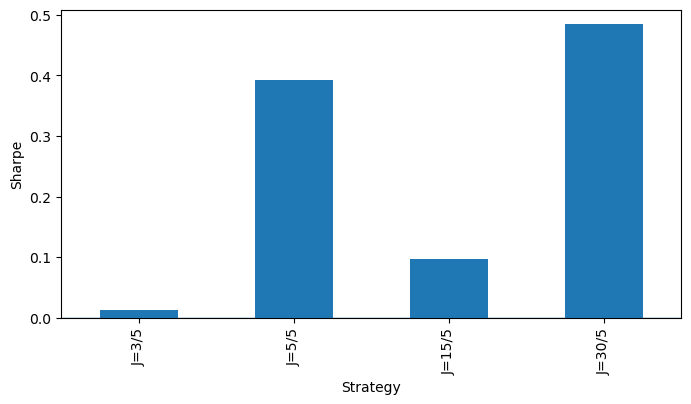

      K=3 Winners (%)  K=3 Losers (%)  K=3 W-L (%)  K=5 Winners (%)  K=5 Losers (%)  K=5 W-L (%)  K=15 Winners (%)  K=15 Losers (%)  K=15 W-L (%)  K=30 Winners (%)  K=30 Losers (%)  K=30 W-L (%)
J=3            -3.626          -4.090        0.464            5.029          -5.566       10.595             5.771           -0.156         5.928             9.375            0.407         8.967
J=5             7.874          -6.562       14.436           10.535         -11.132       21.667             5.901           -1.833         7.734            11.121           -0.480        11.601
J=15            8.950          -2.869       11.819           11.686          -1.322       13.008            12.129           -2.454        14.583            14.424           -2.363        16.786
J=30            9.648         -11.857       21.505            9.867         -14.330       24.197            11.684          -11.984        23.668            14.365           -7.978        22.342
      K=3 Std weekly (%) 

In [54]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
  
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"

TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK',
           'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']
START = datetime.datetime(2015, 1, 2)
END   = datetime.datetime(2024, 12, 31)
K = 5

def list_available_tickers():
    if not os.path.isdir(DATA_DIR):
        raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
    tickers = []
    for fn in os.listdir(DATA_DIR):
        if fn.lower().endswith(".csv"):
            tickers.append(os.path.splitext(fn)[0])
    return sorted(tickers)

def load_ticker_data(ticker, start=None, end=None):
    path = os.path.join(DATA_DIR, f"{ticker}.csv")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.sort_values("Date")
    if start:
        df = df[df["Date"] >= pd.Timestamp(start)]
    if end:
        df = df[df["Date"] <= pd.Timestamp(end)]
    df["Adj Close"] = df["Close"]
    df["Ticker"] = ticker
    return df

def get_data(tickers, start=None, end=None):
    dfs = [load_ticker_data(t, start, end) for t in tickers]
    all_data = pd.concat(dfs)
    return all_data

def prep_data(tickers, start=None, end=None, K=5):
    all_data = get_data(tickers, start, end)

    daily_close_px = (
        all_data.pivot(index="Date", columns="Ticker", values="Adj Close")
        .sort_index()
    )
    daily_pct_change = daily_close_px.pct_change()

    dly_vars = all_data[["Date", "Ticker", "Adj Close", "Volume"]].rename(columns={"Adj Close": "Price"})
    dly_vars["t-1"] = 0.0
    dly_vars["target"] = 0.0

    mkt_ret = daily_pct_change.mean(axis=1).shift(1)
    def cumret(ser, win): return (ser + 1).rolling(win).apply(np.prod, raw=True) - 1

    for coin in tickers:
        sel = dly_vars["Ticker"] == coin
        prices = dly_vars.loc[sel, "Price"]
        dly_vars.loc[sel, "t-1"] = prices.pct_change().shift(1)
        for J in (3, 5, 15, 30):
            dly_vars.loc[sel, f"J_{J}"] = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).apply(np.prod, raw=True) - 1
            dly_vars.loc[sel, f"J_std_{J}"] = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).std()
     
        dly_vars.loc[sel, "target"] = prices.shift(-K) / prices - 1

    dly_vars = dly_vars.dropna().reset_index(drop=True)
    dly_data = dly_vars.set_index("Date")
    dly_target = dly_vars["target"].values
    return dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target

def train_test_split(dly_data, daily_close_px, test_ratio=0.2):
    all_dates = sorted(set(dly_data.index).intersection(set(daily_close_px.index)))
    cutoff = int(len(all_dates) * (1 - test_ratio))
    dates_train = pd.Index(all_dates[:cutoff])
    dates_test  = pd.Index(all_dates[cutoff:])

    X_train_df = dly_data.loc[dates_train]
    X_test_df  = dly_data.loc[dates_test]

    data_train = X_train_df.copy()
    data_test  = X_test_df.copy()

    def split_xy(df):
        X = df.reset_index(drop=False)
        y = X["target"].copy()
        X = X.drop(columns=["target","Price","Ticker","Date"], errors="ignore")
        return X, y

    X_train, y_train = split_xy(X_train_df)
    X_test, y_test = split_xy(X_test_df)

    def _reset_with_date(df):
        out = df.reset_index()
        if "Date" not in out.columns and "index" in out.columns:
            out = out.rename(columns={"index": "Date"})
        return out

    return X_train, y_train, X_test, y_test, _reset_with_date(data_train), _reset_with_date(data_test)

def Momentum(pred_r, date, K, daily_close_px):
    try:
        cur_idx = pred_r.index.get_loc(date)
    except KeyError:
        return np.nan, np.nan, np.nan

    next_idx = cur_idx + K
    if next_idx >= len(pred_r.index):
        return np.nan, np.nan, np.nan

    next_date = pred_r.index[next_idx]

    if (date not in daily_close_px.index) or (next_date not in daily_close_px.index):
        return np.nan, np.nan, np.nan

    ret = pred_r.loc[date].reset_index()
    ret.columns = ["Ticker", "Signal"]

    ret["quantile"] = pd.qcut(ret["Signal"].rank(method="first"), 3, labels=False)

    winners = ret[ret["quantile"] == 2]["Ticker"]
    losers  = ret[ret["quantile"] == 0]["Ticker"]


    w = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(winners)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(winners)] - 1
    )
    l = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(losers)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(losers)] - 1
    )


    momentum_profit = w.mean() - l.mean()
    return (momentum_profit / K * 5), (w.mean() / K * 5), (-l.mean() / K * 5)

def MOM_Profit(returns, K, daily_close_px):
    profits, wins, loss, dates = [], [], [], []
    for date in returns.index[:-K]:
        mom, win, los = Momentum(returns, date, K, daily_close_px)
        if np.isnan(mom):
            continue
        profits.append(mom); wins.append(win); loss.append(los); dates.append(date)


    frame = pd.DataFrame(
        {'MomentumProfit': profits, 'Winners': wins, 'Losers': loss},
        index=dates
    ) * 100.0


    cum_frame = ((1 + frame / 100.0).cumprod() - 1.0) * 100.0

    profit = float(cum_frame['MomentumProfit'].iloc[-1]) if len(cum_frame) else np.nan
    return frame, cum_frame, profit

def PURE_MOM(K, data_test, daily_close_px):
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index":"Date"})
    out = {}
    for J in (3, 5, 15, 30):
        R = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")
        frame, cum_frame, prof = MOM_Profit(R, K, daily_close_px)
        print(f'{J}/{K}  σ={frame.MomentumProfit.std():.4f}  Profit={prof:.2f}%  '
              f'Weekly={frame.MomentumProfit.mean():.2f}%')
        out[J] = (frame, cum_frame, prof)
    return out


all_tickers = list_available_tickers()
tickers = TICKERS or all_tickers
print(f"Using {len(tickers)} tickers: {tickers[:5]}...")

dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target = prep_data(tickers, start=START, end=END, K=K)
X_train, y_train, X_test, y_test, data_train, data_test = train_test_split(dly_data, daily_close_px)

results = PURE_MOM(K, data_test, daily_close_px)

fig, ax = plt.subplots(figsize=(10, 6))
for J in (3, 5, 15, 30):
    ax.plot(results[J][1]['MomentumProfit'], label=f"{J}/{K}")
ax.legend()
ax.set_ylabel("Compounded Return (%)")
plt.show()

try:
    import pandas_datareader.data as web

    rf_dates = pd.Index([])
    for J in (3, 5, 15, 30):
        rf_dates = rf_dates.union(results[J][0].index)

    rf_start = (rf_dates.min().to_pydatetime().date() if len(rf_dates) else START.date())
    rf_end   = (rf_dates.max().to_pydatetime().date() if len(rf_dates) else END.date())

    rf_data = web.DataReader(
        "DGS3MO", "fred",
        datetime.datetime.combine(rf_start, datetime.time.min),
        datetime.datetime.combine(rf_end,   datetime.time.min)
    ).dropna()

    rf_annual = float(rf_data["DGS3MO"].mean()) / 100.0
    print(f"Average 3M T-bill yield over {rf_start}–{rf_end}: {rf_annual*100:.2f}%")

except Exception as e:
    print(" Could not fetch FRED 3M T-bill; using fallback rf_annual = 4.5%.")
    rf_annual = 0.045


periods_per_year =  50

rf_weekly = (1 + rf_annual) ** (1 / periods_per_year) - 1

rows = []
for J in (3, 5, 15, 30):
    s = results[J][0]['MomentumProfit'].astype(float) / 100.0
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) < 2 or s.std(ddof=1) == 0:
        sharpe = np.nan
    else:
        sharpe = (s.mean() - rf_weekly) / s.std(ddof=1) * np.sqrt(periods_per_year)

    mean_w = s.mean()
    std_w  = s.std(ddof=1)
    ann_return = (1 + mean_w) ** periods_per_year - 1
    ann_vol    = std_w * np.sqrt(periods_per_year)

    rows.append({
        "Strategy": f"J={J}/{K}",
        "Obs": len(s),
        "Mean (weekly %)": mean_w * 100,
        "Std (weekly %)": std_w * 100,
        "Sharpe (annual)": sharpe,
        "Ann. Return (%)": ann_return * 100,
        "Ann. Vol (%)": ann_vol * 100,
        "RF (annual %)": rf_annual * 100,
    })

sharpe_table = pd.DataFrame(rows).set_index("Strategy")
display(sharpe_table.round(3))

ax = sharpe_table["Sharpe (annual)"].plot(kind="bar", figsize=(8,4))
ax.set_ylabel("Sharpe")
ax.axhline(0, linewidth=1)
plt.show()


def momentum_summary_table(data_test, daily_close_px, J_list=(3, 5, 15, 30), K_list=(3, 5, 15, 30)):

    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})

    R_dict = {}
    for J in J_list:
        R_dict[J] = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")

    rows = []
    index_labels = []

    for J in J_list:
        row = {}
        R = R_dict[J]

        for K in K_list:
            frame, _, _ = MOM_Profit(R, K, daily_close_px)

            mean_winners = frame["Winners"].mean()
            mean_losers = frame["Losers"].mean()
            mean_wml = mean_winners+mean_losers

            row[f"K={K} Winners (%)"] = mean_winners*100
            row[f"K={K} Losers (%)"] = -mean_losers*100
            row[f"K={K} W-L (%)"] = mean_wml*100

        rows.append(row)
        index_labels.append(f"J={J}")

    summary_df = pd.DataFrame(rows, index=index_labels)
    return summary_df


mom_table = momentum_summary_table(data_test, daily_close_px,
                                   J_list=(3, 5, 15, 30),
                                   K_list=(3, 5, 15, 30))

print(mom_table.round(3))

def momentum_risk_table(
    data_test,
    daily_close_px,
    rf_annual,
    J_list=(3, 5, 15, 30),
    K_list=(3, 5, 15, 30),
    periods_per_year=50,
):
    
    rf_weekly = (1 + rf_annual) ** (1 / periods_per_year) - 1

    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})

    R_dict = {}
    for J in J_list:
        R_dict[J] = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")

    rows = []
    index_labels = []

    for J in J_list:
        row = {}
        R = R_dict[J]

        for K in K_list:
            frame, _, _ = MOM_Profit(R, K, daily_close_px)

            s = frame["MomentumProfit"].astype(float) / 100.0
            s = s.replace([np.inf, -np.inf], np.nan).dropna()

            if len(s) < 2 or s.std(ddof=1) == 0:
                sharpe = np.nan
                std_w = np.nan
                ann_vol = np.nan
            else:
                mean_w = s.mean()
                std_w = s.std(ddof=1)
                sharpe = (mean_w - rf_weekly) / std_w * np.sqrt(periods_per_year)
                ann_vol = std_w * np.sqrt(periods_per_year)

            row[f"K={K} Std weekly (%)"] = std_w * 100 if pd.notna(std_w) else np.nan
            row[f"K={K} Ann Vol (%)"] = ann_vol * 100 if pd.notna(ann_vol) else np.nan
            row[f"K={K} Sharpe (annual)"] = sharpe

        rows.append(row)
        index_labels.append(f"J={J}")

    risk_df = pd.DataFrame(rows, index=index_labels)
    return risk_df

risk_table = momentum_risk_table(
    data_test,
    daily_close_px,
    rf_annual,
    J_list=(3, 5, 15, 30),
    K_list=(3, 5, 15, 30),
    periods_per_year=50,
)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

print(risk_table.round(3))

### Additional analysis: When does the sharpe stop to rise? (J/K: 60, 120, 260 and 580)

Using 15 tickers: ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY']...
3/5  σ=2.0511  Profit=48.98%  Weekly=0.13%
5/5  σ=2.1885  Profit=84.19%  Weekly=0.18%
15/5  σ=2.1123  Profit=28.12%  Weekly=0.09%
30/5  σ=2.1114  Profit=91.66%  Weekly=0.19%
60/5  σ=2.1738  Profit=352.23%  Weekly=0.42%
120/5  σ=2.2870  Profit=361.96%  Weekly=0.43%
260/5  σ=2.3603  Profit=184.83%  Weekly=0.30%
580/5  σ=2.3674  Profit=242.99%  Weekly=0.35%


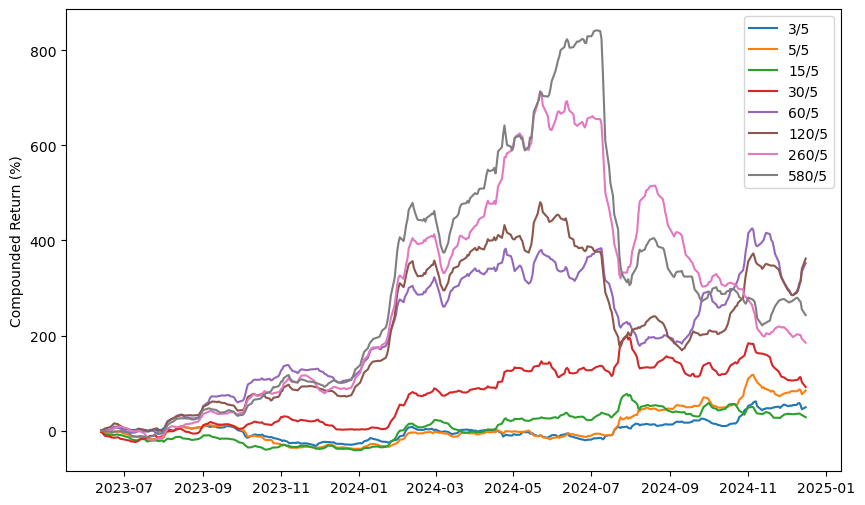

Average 3M T-bill yield over 2023-06-13–2024-12-16: 5.33%


,Obs,Mean (weekly %),Std (weekly %),Sharpe (annual),Ann. Return (%),Ann. Vol (%),RF (annual %)
Strategy,,,,,,,
J=3/5,381,0.126,2.051,0.075,6.475,14.504,5.326
J=5/5,381,0.184,2.189,0.259,9.628,15.475,5.326
J=15/5,381,0.087,2.112,-0.056,4.450,14.936,5.326
J=30/5,381,0.193,2.111,0.298,10.116,14.930,5.326
J=60/5,381,0.420,2.174,1.029,23.330,15.371,5.326
J=120/5,381,0.428,2.287,1.003,23.826,16.171,5.326
J=260/5,381,0.303,2.360,0.596,16.322,16.690,5.326
J=580/5,381,0.352,2.367,0.742,19.217,16.740,5.326


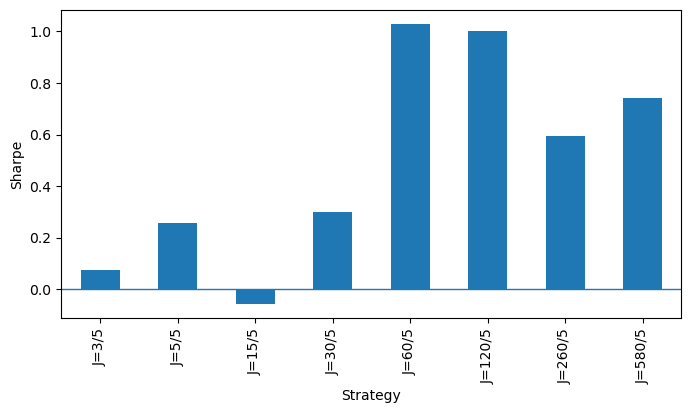

       K=3 Winners (%)  K=3 Losers (%)  K=3 W-L (%)  K=5 Winners (%)  K=5 Losers (%)  K=5 W-L (%)  K=15 Winners (%)  K=15 Losers (%)  K=15 W-L (%)  K=30 Winners (%)  K=30 Losers (%)  K=30 W-L (%)  K=60 Winners (%)  K=60 Losers (%)  K=60 W-L (%)  K=120 Winners (%)  K=120 Losers (%)  K=120 W-L (%)  K=260 Winners (%)  K=260 Losers (%)  K=260 W-L (%)  K=580 Winners (%)  K=580 Losers (%)  K=580 W-L (%)
J=3             -0.885           3.831        2.947            8.303           4.253       12.556             6.046           -4.212         1.834             8.042           -3.119         4.924            14.091          -10.143         3.948             19.554           -19.985         -0.431             24.765           -14.723         10.042                NaN               NaN            NaN
J=5              9.704           2.481       12.184           10.499           7.903       18.402             3.875           -2.452         1.423             8.973           -2.868         6.106   

In [65]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"

TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK',
           'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']
START = datetime.datetime(2015, 1, 2)
END   = datetime.datetime(2024, 12, 31)

K = 5

J_LIST = (3, 5, 15, 30, 60, 120, 260, 580)
K_LIST = (3, 5, 15, 30, 60, 120, 260, 580)


def list_available_tickers():
    if not os.path.isdir(DATA_DIR):
        raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
    tickers = []
    for fn in os.listdir(DATA_DIR):
        if fn.lower().endswith(".csv"):
            tickers.append(os.path.splitext(fn)[0])
    return sorted(tickers)


def load_ticker_data(ticker, start=None, end=None):
    path = os.path.join(DATA_DIR, f"{ticker}.csv")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.sort_values("Date")
    if start:
        df = df[df["Date"] >= pd.Timestamp(start)]
    if end:
        df = df[df["Date"] <= pd.Timestamp(end)]
    df["Adj Close"] = df["Close"]
    df["Ticker"] = ticker
    return df


def get_data(tickers, start=None, end=None):
    dfs = [load_ticker_data(t, start, end) for t in tickers]
    all_data = pd.concat(dfs)
    return all_data


def prep_data(tickers, start=None, end=None, K=5, J_list=J_LIST):
    all_data = get_data(tickers, start, end)

    daily_close_px = (
        all_data.pivot(index="Date", columns="Ticker", values="Adj Close")
        .sort_index()
    )
    daily_pct_change = daily_close_px.pct_change()

    dly_vars = all_data[["Date", "Ticker", "Adj Close", "Volume"]].rename(columns={"Adj Close": "Price"})
    dly_vars["t-1"] = 0.0
    dly_vars["target"] = 0.0

    def cumret(ser, win):
        return (ser + 1).rolling(win).apply(np.prod, raw=True) - 1

    for coin in tickers:
        sel = dly_vars["Ticker"] == coin
        prices = dly_vars.loc[sel, "Price"]
        dly_vars.loc[sel, "t-1"] = prices.pct_change().shift(1)

        for J in J_list:
            dly_vars.loc[sel, f"J_{J}"] = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).apply(np.prod, raw=True) - 1
            dly_vars.loc[sel, f"J_std_{J}"] = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).std()

        dly_vars.loc[sel, "target"] = prices.shift(-K) / prices - 1

    dly_vars = dly_vars.dropna().reset_index(drop=True)
    dly_data = dly_vars.set_index("Date")
    dly_target = dly_vars["target"].values
    return dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target


def train_test_split(dly_data, daily_close_px, test_ratio=0.2):
    all_dates = sorted(set(dly_data.index).intersection(set(daily_close_px.index)))
    cutoff = int(len(all_dates) * (1 - test_ratio))
    dates_train = pd.Index(all_dates[:cutoff])
    dates_test  = pd.Index(all_dates[cutoff:])

    X_train_df = dly_data.loc[dates_train]
    X_test_df  = dly_data.loc[dates_test]

    data_train = X_train_df.copy()
    data_test  = X_test_df.copy()

    def split_xy(df):
        X = df.reset_index(drop=False)
        y = X["target"].copy()
        X = X.drop(columns=["target", "Price", "Ticker", "Date"], errors="ignore")
        return X, y

    X_train, y_train = split_xy(X_train_df)
    X_test, y_test = split_xy(X_test_df)

    def _reset_with_date(df):
        out = df.reset_index()
        if "Date" not in out.columns and "index" in out.columns:
            out = out.rename(columns={"index": "Date"})
        return out

    return X_train, y_train, X_test, y_test, _reset_with_date(data_train), _reset_with_date(data_test)


def Momentum(pred_r, date, K, daily_close_px):
    try:
        cur_idx = pred_r.index.get_loc(date)
    except KeyError:
        return np.nan, np.nan, np.nan

    next_idx = cur_idx + K
    if next_idx >= len(pred_r.index):
        return np.nan, np.nan, np.nan

    next_date = pred_r.index[next_idx]

    if (date not in daily_close_px.index) or (next_date not in daily_close_px.index):
        return np.nan, np.nan, np.nan

    ret = pred_r.loc[date].reset_index()
    ret.columns = ["Ticker", "Signal"]

    ret["quantile"] = pd.qcut(ret["Signal"].rank(method="first"), 3, labels=False)

    winners = ret[ret["quantile"] == 2]["Ticker"]
    losers  = ret[ret["quantile"] == 0]["Ticker"]

    w = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(winners)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(winners)] - 1
    )
    l = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(losers)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(losers)] - 1
    )

    momentum_profit = w.mean() - l.mean()
    return (momentum_profit / K * 5), (w.mean() / K * 5), (-l.mean() / K * 5)


def MOM_Profit(returns, K, daily_close_px):
    profits, wins, loss, dates = [], [], [], []
    for date in returns.index[:-K]:
        mom, win, los = Momentum(returns, date, K, daily_close_px)
        if np.isnan(mom):
            continue
        profits.append(mom)
        wins.append(win)
        loss.append(los)
        dates.append(date)

    frame = pd.DataFrame(
        {'MomentumProfit': profits, 'Winners': wins, 'Losers': loss},
        index=dates
    ) * 100.0

    cum_frame = ((1 + frame / 100.0).cumprod() - 1.0) * 100.0

    profit = float(cum_frame['MomentumProfit'].iloc[-1]) if len(cum_frame) else np.nan
    return frame, cum_frame, profit


def PURE_MOM(K, data_test, daily_close_px, J_list=J_LIST):
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})
    out = {}
    for J in J_list:
        R = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")
        frame, cum_frame, prof = MOM_Profit(R, K, daily_close_px)
        print(f'{J}/{K}  σ={frame.MomentumProfit.std():.4f}  Profit={prof:.2f}%  '
              f'Weekly={frame.MomentumProfit.mean():.2f}%')
        out[J] = (frame, cum_frame, prof)
    return out


all_tickers = list_available_tickers()
tickers = TICKERS or all_tickers
print(f"Using {len(tickers)} tickers: {tickers[:5]}...")

dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target = prep_data(
    tickers, start=START, end=END, K=K, J_list=J_LIST
)
X_train, y_train, X_test, y_test, data_train, data_test = train_test_split(dly_data, daily_close_px)

results = PURE_MOM(K, data_test, daily_close_px, J_list=J_LIST)

fig, ax = plt.subplots(figsize=(10, 6))
for J in J_LIST:
    ax.plot(results[J][1]['MomentumProfit'], label=f"{J}/{K}")
ax.legend()
ax.set_ylabel("Compounded Return (%)")
plt.show()


try:
    import pandas_datareader.data as web

    rf_dates = pd.Index([])
    for J in J_LIST:
        rf_dates = rf_dates.union(results[J][0].index)

    rf_start = (rf_dates.min().to_pydatetime().date() if len(rf_dates) else START.date())
    rf_end   = (rf_dates.max().to_pydatetime().date() if len(rf_dates) else END.date())

    rf_data = web.DataReader(
        "DGS3MO", "fred",
        datetime.datetime.combine(rf_start, datetime.time.min),
        datetime.datetime.combine(rf_end,   datetime.time.min)
    ).dropna()

    rf_annual = float(rf_data["DGS3MO"].mean()) / 100.0
    print(f"Average 3M T-bill yield over {rf_start}–{rf_end}: {rf_annual*100:.2f}%")

except Exception as e:
    print(" Could not fetch FRED 3M T-bill; using fallback rf_annual = 4.5%.")
    rf_annual = 0.045


periods_per_year = 50
rf_weekly = (1 + rf_annual) ** (1 / periods_per_year) - 1

rows = []
for J in J_LIST:
    s = results[J][0]['MomentumProfit'].astype(float) / 100.0
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) < 2 or s.std(ddof=1) == 0:
        sharpe = np.nan
    else:
        sharpe = (s.mean() - rf_weekly) / s.std(ddof=1) * np.sqrt(periods_per_year)

    mean_w = s.mean()
    std_w  = s.std(ddof=1)
    ann_return = (1 + mean_w) ** periods_per_year - 1
    ann_vol    = std_w * np.sqrt(periods_per_year)

    rows.append({
        "Strategy": f"J={J}/{K}",
        "Obs": len(s),
        "Mean (weekly %)": mean_w * 100,
        "Std (weekly %)": std_w * 100,
        "Sharpe (annual)": sharpe,
        "Ann. Return (%)": ann_return * 100,
        "Ann. Vol (%)": ann_vol * 100,
        "RF (annual %)": rf_annual * 100,
    })

sharpe_table = pd.DataFrame(rows).set_index("Strategy")
try:
    display(sharpe_table.round(3))
except NameError:
    print(sharpe_table.round(3))

ax = sharpe_table["Sharpe (annual)"].plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Sharpe")
ax.axhline(0, linewidth=1)
plt.show()


def momentum_summary_table(data_test, daily_close_px, J_list=J_LIST, K_list=K_LIST):
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})

    R_dict = {}
    for J in J_list:
        R_dict[J] = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")

    rows = []
    index_labels = []

    for J in J_list:
        row = {}
        R = R_dict[J]

        for K_ in K_list:
            frame, _, _ = MOM_Profit(R, K_, daily_close_px)

            mean_winners = frame["Winners"].mean()
            mean_losers  = frame["Losers"].mean()
            mean_wml     = mean_winners + mean_losers

            row[f"K={K_} Winners (%)"] = mean_winners * 100
            row[f"K={K_} Losers (%)"]  = mean_losers * 100
            row[f"K={K_} W-L (%)"]     = mean_wml * 100

        rows.append(row)
        index_labels.append(f"J={J}")

    summary_df = pd.DataFrame(rows, index=index_labels)
    return summary_df


mom_table = momentum_summary_table(
    data_test, daily_close_px,
    J_list=J_LIST,
    K_list=K_LIST
)

print(mom_table.round(3))


def momentum_risk_table(
    data_test,
    daily_close_px,
    rf_annual,
    J_list=J_LIST,
    K_list=K_LIST,
    periods_per_year=50,
):
    rf_weekly = (1 + rf_annual) ** (1 / periods_per_year) - 1

    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})

    R_dict = {}
    for J in J_list:
        R_dict[J] = data_test.pivot(index="Date", columns="Ticker", values=f"J_{J}")

    rows = []
    index_labels = []

    for J in J_list:
        row = {}
        R = R_dict[J]

        for K_ in K_list:
            frame, _, _ = MOM_Profit(R, K_, daily_close_px)

            s = frame["MomentumProfit"].astype(float) / 100.0
            s = s.replace([np.inf, -np.inf], np.nan).dropna()

            if len(s) < 2 or s.std(ddof=1) == 0:
                sharpe = np.nan
                std_w = np.nan
                ann_vol = np.nan
            else:
                mean_w = s.mean()
                std_w = s.std(ddof=1)
                sharpe = (mean_w - rf_weekly) / std_w * np.sqrt(periods_per_year)
                ann_vol = std_w * np.sqrt(periods_per_year)

            row[f"K={K_} Std weekly (%)"]   = std_w * 100 if pd.notna(std_w) else np.nan
            row[f"K={K_} Ann Vol (%)"]      = ann_vol * 100 if pd.notna(ann_vol) else np.nan
            row[f"K={K_} Sharpe (annual)"]  = sharpe

        rows.append(row)
        index_labels.append(f"J={J}")

    risk_df = pd.DataFrame(rows, index=index_labels)
    return risk_df


risk_table = momentum_risk_table(
    data_test,
    daily_close_px,
    rf_annual,
    J_list=J_LIST,
    K_list=K_LIST,
    periods_per_year=50,
)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

print(risk_table.round(3))

combined = mom_table.join(risk_table, how="outer")

mom_cols = [c for c in combined.columns if ("Winners" in c or "Losers" in c or "W-L" in c)]
risk_cols = [c for c in combined.columns if c not in mom_cols]
combined = combined[mom_cols + risk_cols]


### Momentum trading strategy (Volatility adjusted)

VolAdj 3/5  σ=2.0417  Profit=-17.21%  Weekly=-0.03%
VolAdj 5/5  σ=2.0746  Profit=60.55%  Weekly=0.15%
VolAdj 15/5  σ=2.0313  Profit=31.36%  Weekly=0.09%
VolAdj 30/5  σ=2.0322  Profit=109.68%  Weekly=0.21%


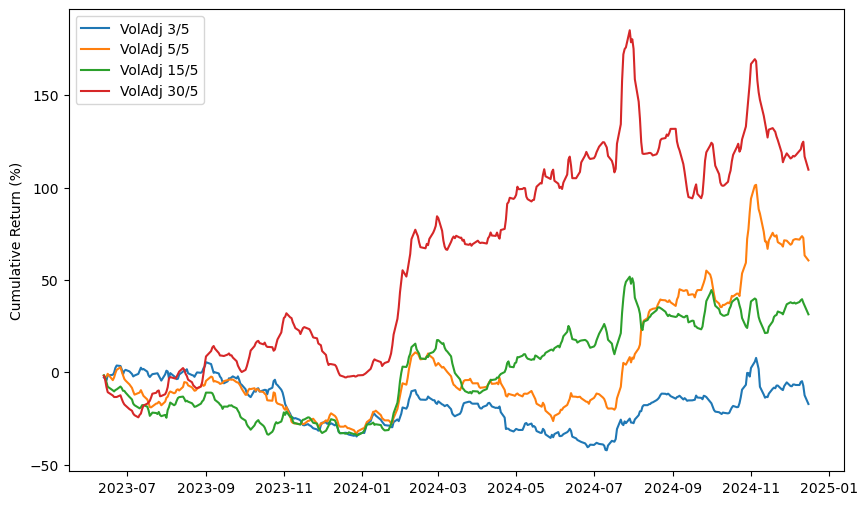

,Obs,Mean (weekly %),Std (weekly %),Sharpe (annual),Ann. Return (%),Ann. Vol (%),RF (annual %)
Strategy,,,,,,,
VolAdj J=3/5,381,-0.029,2.042,-0.459,-1.427,14.437,5.326
VolAdj J=5/5,381,0.146,2.075,0.142,7.546,14.670,5.326
VolAdj J=15/5,381,0.092,2.031,-0.041,4.706,14.363,5.326
VolAdj J=30/5,381,0.215,2.032,0.387,11.333,14.370,5.326


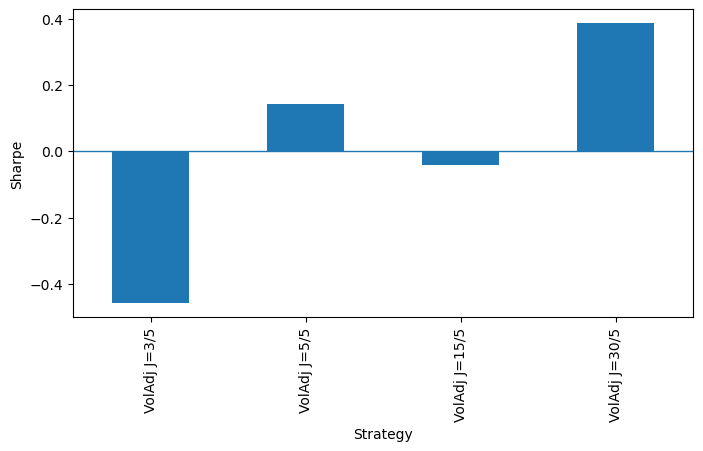

In [66]:

def Momentum_VA(pred_r, date, K, daily_close_px):
    try:
        cur_idx = pred_r.index.get_loc(date)
    except KeyError:
        return np.nan, np.nan, np.nan

    next_idx = cur_idx + K
    if next_idx >= len(pred_r.index):
        return np.nan, np.nan, np.nan

    next_date = pred_r.index[next_idx]

    if (date not in daily_close_px.index) or (next_date not in daily_close_px.index):
        return np.nan, np.nan, np.nan

    ret = pred_r.loc[date].dropna().reset_index()
    ret.columns = ["Ticker", "Signal"]
    if len(ret) < 3:
        return np.nan, np.nan, np.nan

    ret["quantile"] = pd.qcut(ret["Signal"].rank(method="first"), 3, labels=False)

    winners = ret[ret["quantile"] == 2]["Ticker"]
    losers  = ret[ret["quantile"] == 0]["Ticker"]

    if len(winners) == 0 or len(losers) == 0:
        return np.nan, np.nan, np.nan

    w = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(winners)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(winners)] - 1
    )
    l = (
        daily_close_px.loc[next_date, daily_close_px.columns.isin(losers)] /
        daily_close_px.loc[date,      daily_close_px.columns.isin(losers)] - 1
    )

    momentum_profit = w.mean() - l.mean()
    return (momentum_profit / K * 5), (w.mean() / K * 5), (-l.mean() / K * 5)

def MOM_Profit_VA(returns, K, daily_close_px):
    profits, wins, loss, dates = [], [], [], []
    for date in returns.index[:-K]:
        mom, win, los = Momentum_VA(returns, date, K, daily_close_px)
        if np.isnan(mom):
            continue
        profits.append(mom); wins.append(win); loss.append(los); dates.append(date)

    frame = pd.DataFrame(
        {"MomentumProfit": profits, "Winners": wins, "Losers": loss},
        index=dates
    ) * 100.0

    cum_frame = ((1 + frame / 100.0).cumprod() - 1.0) * 100.0
    profit = float(cum_frame["MomentumProfit"].iloc[-1]) if len(cum_frame) else np.nan
    return frame, cum_frame, profit

def VOLADJ_MOM(K, data_test, daily_close_px):
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})

    out = {}
    for J in (3, 5, 15, 30):
        tmp = data_test.copy()

        denom = tmp[f"J_std_{J}"].replace(0, np.nan)
        tmp[f"VA_{J}"] = tmp[f"J_{J}"] / denom
        tmp[f"VA_{J}"] = tmp[f"VA_{J}"].replace([np.inf, -np.inf], np.nan)

        R = tmp.pivot(index="Date", columns="Ticker", values=f"VA_{J}")

        frame, cum_frame, prof = MOM_Profit_VA(R, K, daily_close_px)
        print(f"VolAdj {J}/{K}  σ={frame.MomentumProfit.std():.4f}  "
              f"Profit={prof:.2f}%  Weekly={frame.MomentumProfit.mean():.2f}%")
        out[J] = (frame, cum_frame, prof)
    return out

vol_results = VOLADJ_MOM(K, data_test, daily_close_px)

fig, ax = plt.subplots(figsize=(10, 6))
for J in (3, 5, 15, 30):
    ax.plot(vol_results[J][1]['MomentumProfit'], label=f"VolAdj {J}/{K}")
ax.legend()
ax.set_ylabel("Cumulative Return (%)")
plt.show()

rows_va = []
for J in (3, 5, 15, 30):
    s = vol_results[J][0]['MomentumProfit'].astype(float) / 100.0
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) < 2 or s.std(ddof=1) == 0:
        sharpe = np.nan
    else:
        sharpe = (s.mean() - rf_weekly) / s.std(ddof=1) * np.sqrt(periods_per_year)

    mean_w = s.mean()
    std_w  = s.std(ddof=1)
    ann_return = (1 + mean_w) ** periods_per_year - 1
    ann_vol    = std_w * np.sqrt(periods_per_year)

    rows_va.append({
        "Strategy": f"VolAdj J={J}/{K}",
        "Obs": len(s),
        "Mean (weekly %)": mean_w * 100,
        "Std (weekly %)": std_w * 100,
        "Sharpe (annual)": sharpe,
        "Ann. Return (%)": ann_return * 100,
        "Ann. Vol (%)": ann_vol * 100,
        "RF (annual %)": rf_annual * 100,
    })

sharpe_table_va = pd.DataFrame(rows_va).set_index("Strategy")
display(sharpe_table_va.round(3))

ax = sharpe_table_va["Sharpe (annual)"].plot(
    kind="bar", figsize=(8, 4),
   
)
ax.set_ylabel("Sharpe")
ax.axhline(0, linewidth=1)
plt.show()


### Momentum trading strategy (Volatility and Volume adjusted)

Vol+VolmAdj 3/5 σ=1.9431  Profit=21.72%  Weekly=0.07%
Vol+VolmAdj 5/5 σ=2.0815  Profit=29.61%  Weekly=0.09%
Vol+VolmAdj 15/5 σ=2.0325  Profit=63.10%  Weekly=0.15%
Vol+VolmAdj 30/5 σ=2.1067  Profit=188.93%  Weekly=0.32%


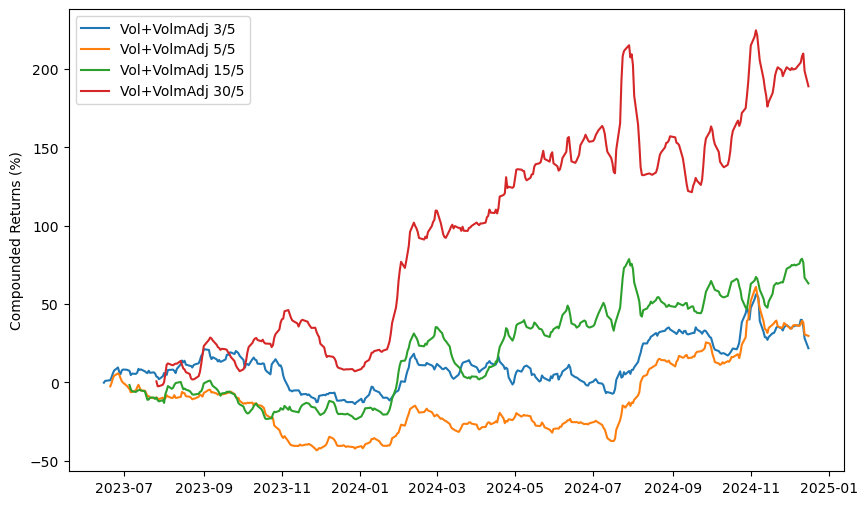

,Obs,Mean (weekly %),Std (weekly %),Sharpe (annual),Ann. Return (%),Ann. Vol (%),RF (annual %)
Strategy,,,,,,,
Vol+VolmAdj J=3/5,379,0.071,1.943,-0.120,3.599,13.740,5.326
Vol+VolmAdj J=5/5,377,0.090,2.082,-0.046,4.613,14.718,5.326
Vol+VolmAdj J=15/5,367,0.154,2.033,0.174,7.990,14.372,5.326
Vol+VolmAdj J=30/5,352,0.324,2.107,0.738,17.543,14.897,5.326


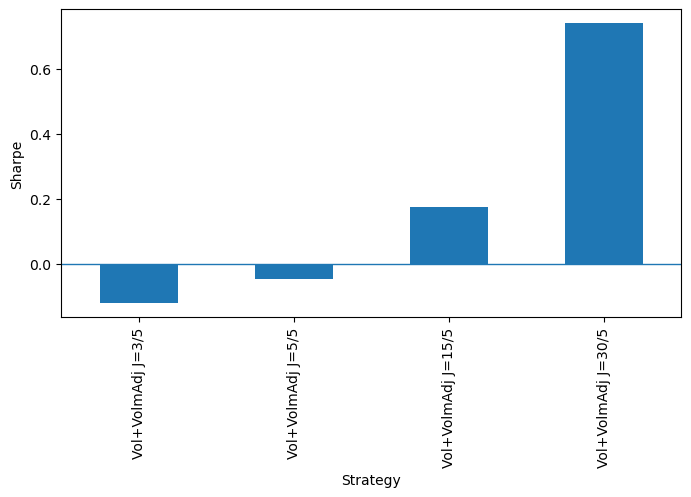

In [67]:
def VOLVOLMADJ_MOM(K, data_test, daily_close_px, vol_col="Volume"):
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index": "Date"})

    if vol_col not in data_test.columns:
        raise KeyError(f"'{vol_col}' not found in data_test.columns. Available: {list(data_test.columns)}")

    tmp0 = data_test.copy()
    tmp0 = tmp0.sort_values(["Ticker", "Date"]).copy()

    tmp0[vol_col] = tmp0[vol_col].replace(0, np.nan)
    tmp0["_log_vol"] = np.log(tmp0[vol_col])

    out = {}
    for J in (3, 5, 15, 30):
        tmp = tmp0.copy()

        tmp[f"V_std_{J}"] = (
            tmp.groupby("Ticker")["_log_vol"]
               .rolling(J, min_periods=J)
               .std()
               .reset_index(level=0, drop=True)
        )

        denom_ret = tmp[f"J_std_{J}"].replace(0, np.nan)
        denom_vol = tmp[f"V_std_{J}"].replace(0, np.nan)
        denom = (denom_ret * denom_vol)

        tmp[f"VolVolmAdj_{J}"] = tmp[f"J_{J}"] / denom
        tmp[f"VolVolmAdj_{J}"] = tmp[f"VolVolmAdj_{J}"].replace([np.inf, -np.inf], np.nan)

        R = tmp.pivot(index="Date", columns="Ticker", values=f"VolVolmAdj_{J}")

        frame, cum_frame, prof = MOM_Profit_VA(R, K, daily_close_px)
        print(f"Vol+VolmAdj {J}/{K} σ={frame.MomentumProfit.std():.4f}  "
              f"Profit={prof:.2f}%  Weekly={frame.MomentumProfit.mean():.2f}%")
        out[J] = (frame, cum_frame, prof)

    return out

volvolm_results = VOLVOLMADJ_MOM(K, data_test, daily_close_px, vol_col="Volume")

fig, ax = plt.subplots(figsize=(10, 6))
for J in (3, 5, 15, 30):
    ax.plot(volvolm_results[J][1]['MomentumProfit'], label=f"Vol+VolmAdj {J}/{K}")
ax.legend()
ax.set_ylabel("Compounded Returns (%)")
plt.show()


rows_volvolm = []
for J in (3, 5, 15, 30):
    s = volvolm_results[J][0]['MomentumProfit'].astype(float) / 100.0
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) < 2 or s.std(ddof=1) == 0:
        sharpe = np.nan
    else:
        sharpe = (s.mean() - rf_weekly) / s.std(ddof=1) * np.sqrt(periods_per_year)

    mean_w = s.mean()
    std_w  = s.std(ddof=1)
    ann_return = (1 + mean_w) ** periods_per_year - 1
    ann_vol    = std_w * np.sqrt(periods_per_year)

    rows_volvolm.append({
        "Strategy": f"Vol+VolmAdj J={J}/{K}",
        "Obs": len(s),
        "Mean (weekly %)": mean_w * 100,
        "Std (weekly %)": std_w * 100,
        "Sharpe (annual)": sharpe,
        "Ann. Return (%)": ann_return * 100,
        "Ann. Vol (%)": ann_vol * 100,
        "RF (annual %)": rf_annual * 100,
    })

sharpe_table_volvolm = pd.DataFrame(rows_volvolm).set_index("Strategy")
display(sharpe_table_volvolm.round(3))

ax = sharpe_table_volvolm["Sharpe (annual)"].plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Sharpe")
ax.axhline(0, linewidth=1)
plt.show()

### 30/5 Volatility and volume adjusted momentum trading strategy chosen for comparison with RF model

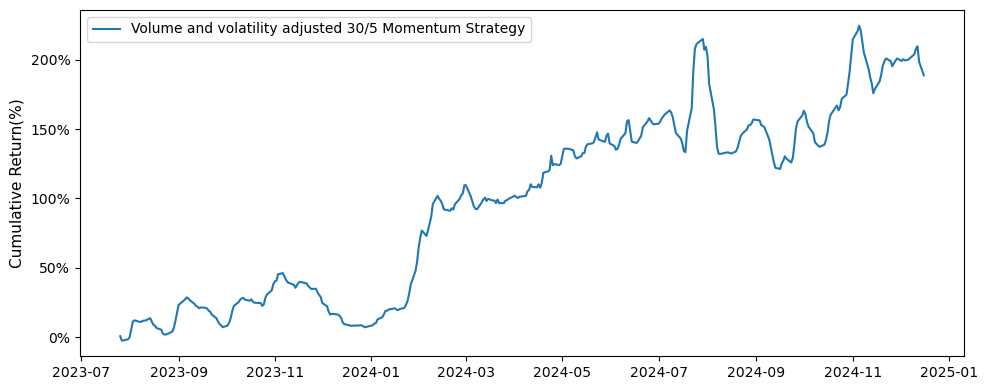

In [68]:
from matplotlib.ticker import PercentFormatter
J_star = 30    
K_star = K      

cum_volvolm = volvolm_results[J_star][1]["MomentumProfit"]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(cum_volvolm.index, cum_volvolm.values, label=f"Volume and volatility adjusted {J_star}/{K_star} Momentum Strategy")

ax.set_ylabel("Cumulative Return(%)", fontsize=11)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.legend(loc="upper left", frameon=True)


plt.tight_layout()
fig.savefig("figure19_voladj_3030.png", dpi=300, bbox_inches="tight")
plt.show()


### Random Forest Regressor: Price, momentum, volatility and volume as input variables

After date filter: 2023-01-03 00:00:00 → 2024-12-31 00:00:00
Loaded 15 tickers: ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD'] ...
Date span: 2023-01-03 → 2024-12-31 | rows=7,530
Tickers kept after MIN_HISTORY filter (60): 15
Feature matrix: X=(6990, 12), y=(6990,)
Train: (5580, 12), Test: (1410, 12)
RandomForest — R^2 train: 0.068, test: -0.073 | RMSE train: 0.03144, test: 0.03482


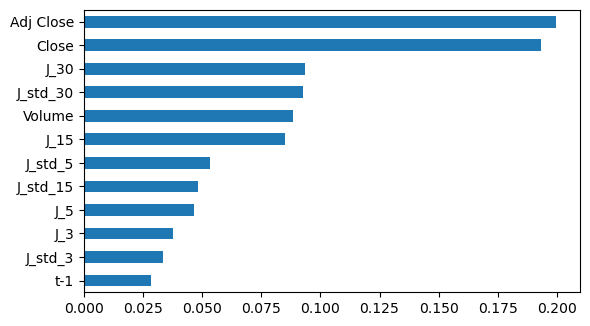

Backtest observations: 461 rebalancing dates


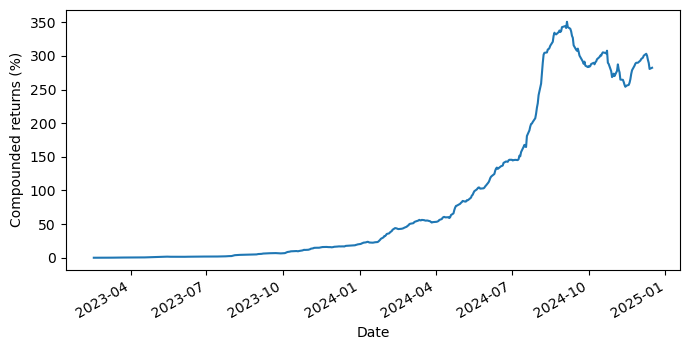

LS mean per rebalance: 1.2545% | std: 2.1259%


In [50]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

DATA_FOLDER = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
K_HOLD = 5     
TEST_SIZE = 0.20
MIN_HISTORY = 60

import os

def load_all_from_folder(folder_path):
    rows = []
    for file in os.listdir(folder_path):
        if not file.lower().endswith(".csv"):
            continue
        path = os.path.join(folder_path, file)
        df = pd.read_csv(path)
        keep = ["Date", "Ticker", "Close", "Volume"]
        missing = [c for c in keep if c not in df.columns]
        if missing:
            raise ValueError(f"{file} missing required columns: {missing}")
        df = df[keep].copy()
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date").reset_index(drop=True)
        df["Adj Close"] = df["Close"]
        rows.append(df)
    full = pd.concat(rows, ignore_index=True)
    full = full.drop_duplicates(subset=["Ticker", "Date"]).sort_values(["Ticker", "Date"])
    return full

full = load_all_from_folder(DATA_FOLDER)

START = pd.Timestamp("2023-01-01")
END   = pd.Timestamp("2025-01-01")

full = full[(full["Date"] >= START) & (full["Date"] <= END)].copy()

print("After date filter:", full["Date"].min(), "→", full["Date"].max())

tickers = sorted(full["Ticker"].unique().tolist())
print(f"Loaded {len(tickers)} tickers:", tickers[:6], "..." if len(tickers) > 6 else "")
print(f"Date span: {full['Date'].min().date()} → {full['Date'].max().date()} | rows={len(full):,}")

ok_counts = full.groupby("Ticker")["Date"].count()
keep = ok_counts[ok_counts >= MIN_HISTORY].index.tolist()
full = full[full["Ticker"].isin(keep)].copy()
tickers = keep
print(f"Tickers kept after MIN_HISTORY filter ({MIN_HISTORY}): {len(tickers)}")

def make_features(panel_df, tickers, K):
    px = panel_df.pivot(index="Date", columns="Ticker", values="Adj Close").sort_index()
    ret = px.pct_change()

    mkt_ret = ret.mean(axis=1)

    mkt_cum_3  = (mkt_ret + 1).shift(1).rolling(3).apply(np.prod, raw=True)  - 1
    mkt_cum_5  = (mkt_ret + 1).shift(1).rolling(5).apply(np.prod, raw=True)  - 1
    mkt_cum_15 = (mkt_ret + 1).shift(1).rolling(15).apply(np.prod, raw=True) - 1
    mkt_cum_30 = (mkt_ret + 1).shift(1).rolling(30).apply(np.prod, raw=True) - 1

    mkt_std_3  = (mkt_ret + 1).shift(1).rolling(3).std()
    mkt_std_5  = (mkt_ret + 1).shift(1).rolling(5).std()
    mkt_std_15 = (mkt_ret + 1).shift(1).rolling(15).std()
    mkt_std_30 = (mkt_ret + 1).shift(1).rolling(30).std()

    d = panel_df.sort_values(["Ticker", "Date"]).copy()
    d["Price"]  = d["Adj Close"]
    d["t-1"]    = np.nan
    d["J_3"]    = np.nan
    d["J_5"]    = np.nan
    d["J_15"]   = np.nan
    d["J_30"]   = np.nan
    d["J_std_3"]  = np.nan
    d["J_std_5"]  = np.nan
    d["J_std_15"] = np.nan
    d["J_std_30"] = np.nan

    d["mkt_t-1"]      = np.nan
    d["mkt_J_ret_3"]  = np.nan
    d["mkt_J_ret_5"]  = np.nan
    d["mkt_J_ret_15"] = np.nan
    d["mkt_J_ret_30"] = np.nan
    d["mkt_J_std_3"]  = np.nan
    d["mkt_J_std_5"]  = np.nan
    d["mkt_J_std_15"] = np.nan
    d["mkt_J_std_30"] = np.nan

    for t in tickers:
        mask = d["Ticker"].eq(t)
        dd   = d.loc[mask, ["Date", "Price", "Volume"]].copy()

        r = dd["Price"].pct_change()

        J_3  = (r + 1).shift(2).rolling(2).apply(np.prod, raw=True)  - 1 
        J_5  = (r + 1).shift(1).rolling(6).apply(np.prod, raw=True)  - 1
        J_15 = (r + 1).shift(1).rolling(14).apply(np.prod, raw=True) - 1
        J_30 = (r + 1).shift(1).rolling(29).apply(np.prod, raw=True) - 1

        J_std_3  = (r + 1).shift(1).rolling(2).std()
        J_std_5  = (r + 1).shift(1).rolling(6).std()
        J_std_15 = (r + 1).shift(1).rolling(14).std()
        J_std_30 = (r + 1).rolling(29).std()

        d.loc[mask, "t-1"]      = r.shift(1).values
        d.loc[mask, "J_3"]      = J_3.values
        d.loc[mask, "J_5"]      = J_5.values
        d.loc[mask, "J_15"]     = J_15.values
        d.loc[mask, "J_30"]     = J_30.values
        d.loc[mask, "J_std_3"]  = J_std_3.values
        d.loc[mask, "J_std_5"]  = J_std_5.values
        d.loc[mask, "J_std_15"] = J_std_15.values
        d.loc[mask, "J_std_30"] = J_std_30.values

        d.loc[mask, "mkt_t-1"]      = mkt_ret.shift(1).reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_ret_3"]  = mkt_cum_3.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_ret_5"]  = mkt_cum_5.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_ret_15"] = mkt_cum_15.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_ret_30"] = mkt_cum_30.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_std_3"]  = mkt_std_3.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_std_5"]  = mkt_std_5.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_std_15"] = mkt_std_15.reindex(dd["Date"]).values
        d.loc[mask, "mkt_J_std_30"] = mkt_std_30.reindex(dd["Date"]).values

    d["target"] = np.nan
    for t in tickers:
        mask = d["Ticker"].eq(t)
        dd = d.loc[mask, ["Date", "Price"]].reset_index()
        price = dd["Price"].values
        future = pd.Series(price).shift(-K) / pd.Series(price) - 1.0
        d.loc[mask, "target"] = future.values

    d = d.dropna().reset_index(drop=True)

    daily_close_px = px.loc[d["Date"].min(): d["Date"].max()].copy()
    daily_ret = daily_close_px.pct_change()

    dly_data = d.copy()

    drop_mkt = [
        'mkt_t-1','mkt_J_ret_3','mkt_J_ret_5','mkt_J_ret_15','mkt_J_ret_30',
        'mkt_J_std_3','mkt_J_std_5','mkt_J_std_15','mkt_J_std_30'
    ]
    dly_vars = d.drop(columns=drop_mkt + ["Ticker","Date"]).copy()

    y = dly_vars["target"].values
    X = dly_vars.drop(columns=["target", "Price"]).copy()  

    return X, y, dly_data, daily_close_px, daily_ret

X_all, y_all, dly_data, daily_close_px, daily_ret = make_features(full, tickers, K=K_HOLD)
print(f"Feature matrix: X={X_all.shape}, y={y_all.shape}")

dates = dly_data["Date"].sort_values().unique()
cut = int((1 - TEST_SIZE) * len(dates))
train_dates, test_dates = dates[:cut], dates[cut:]

train_mask = dly_data["Date"].isin(train_dates)
test_mask  = dly_data["Date"].isin(test_dates)

X_full_model = dly_data.drop(columns=[
    'Ticker','Date',
    'mkt_t-1','mkt_J_ret_3','mkt_J_ret_5','mkt_J_ret_15','mkt_J_ret_30',
    'mkt_J_std_3','mkt_J_std_5','mkt_J_std_15','mkt_J_std_30'
]).copy()
X_full_model = X_full_model.drop(columns=["Price"])
y_full = X_full_model["target"].values
X_full_model = X_full_model.drop(columns=["target"])

X_train = X_full_model.loc[train_mask.values].reset_index(drop=True)
y_train = y_full[train_mask.values]
X_test  = X_full_model.loc[test_mask.values].reset_index(drop=True)
y_test  = y_full[test_mask.values]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


rf = RandomForestRegressor(
    n_estimators=450,
    max_features=3,
    max_depth=4,
    min_samples_split=3,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=0
)
rf.fit(X_train, y_train)

pred_train = rf.predict(X_train)
pred_test  = rf.predict(X_test)

r2_tr = r2_score(y_train, pred_train)
r2_te = r2_score(y_test, pred_test)
rmse_tr = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_te = np.sqrt(mean_squared_error(y_test, pred_test))


print(f"RandomForest — R^2 train: {r2_tr:.3f}, test: {r2_te:.3f} | RMSE train: {rmse_tr:.5f}, test: {rmse_te:.5f}")

imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(6, max(3, len(imp)*0.28)))
imp.plot(kind="barh")
plt.tight_layout()
plt.show()


def long_short_backtest(dly_data, preds, daily_px, k_steps=K_HOLD):
    df = dly_data[["Date","Ticker"]].copy().reset_index(drop=True)
    df["pred"] = preds

    pred_pvt = df.pivot(index="Date", columns="Ticker", values="pred").sort_index()

    px = daily_px.reindex(pred_pvt.index.union(daily_px.index)).sort_index()
    px = px.ffill()
    idx = px.index

    ls_returns = []
    ls_dates   = []

    for i, dt in enumerate(pred_pvt.index):
        if dt not in idx:
            continue
        pos = idx.get_indexer([dt])[0]
        fpos = pos + k_steps
        if fpos >= len(idx):
            break
        future_dt = idx[fpos]

        row = pred_pvt.loc[dt]
        valid = row.index[(~px.loc[dt, row.index].isna()) & (~px.loc[future_dt, row.index].isna())]

        if len(valid) < 6:
            continue 

        row = row.loc[valid]
        ranks = row.rank(method="first")
        terc = pd.qcut(ranks, 3, labels=False)

        winners = row.index[terc == 2]
        losers  = row.index[terc == 0]

        if len(winners) == 0 or len(losers) == 0:
            continue

        wret = (px.loc[future_dt, winners] / px.loc[dt, winners] - 1).mean()
        lret = (px.loc[future_dt, losers] / px.loc[dt, losers] - 1).mean()

        ls_returns.append(((wret - lret)/K_HOLD)*5)
        ls_dates.append(dt)

    ls = pd.Series(ls_returns, index=pd.to_datetime(ls_dates)).sort_index()
    return ls

pred_full = np.empty(len(dly_data))
pred_full[:] = np.nan
pred_full[train_mask.values] = pred_train
pred_full[test_mask.values]  = pred_test

ls = long_short_backtest(dly_data, pred_full, daily_close_px, k_steps=K_HOLD)
print(f"Backtest observations: {ls.shape[0]} rebalancing dates")

cumret = (1 + ls).cumprod() - 1
plt.figure(figsize=(7,3.6))
cumret.plot()
plt.ylabel("Compounded returns (%)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

print(f"LS mean per rebalance: {ls.mean():.4%} | std: {ls.std():.4%}")


### Random Forest Regressor vs. 30/5 Volatility and volume adjusted momentum trading strategy

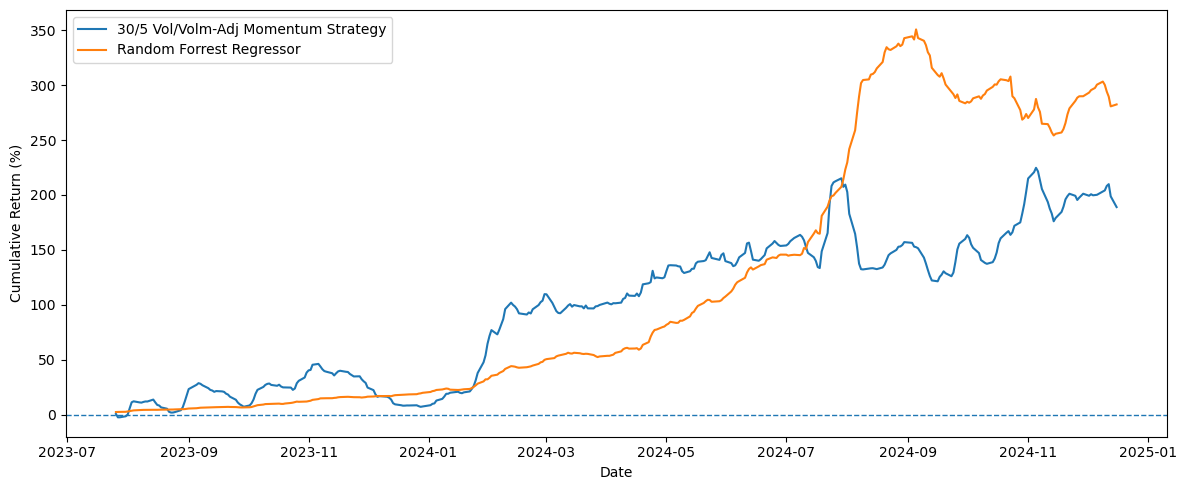

Summary Table (Weekly return, volatility, Sharpe, Max Drawdown):


,r (weekly %),σ (weekly %),Sharpe ratio,Max drawdown (%)
30/5 Vol/Volm-Adj,0.32,2.11,0.74,-29.77
Random Forest,1.30,2.24,3.79,-27.46


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

J_star = 30
K_star = 5
periods_per_year = 50

mom_frame = volvolm_results[J_star][0]
mom_r = (mom_frame["MomentumProfit"] / 100.0).rename("MOM")
rf_r = pd.Series(ls, name="RF").astype(float)

mom_cum_pct = ((1.0 + mom_r).cumprod() - 1.0) * 100.0
rf_cum_pct = ((1.0 + rf_r).cumprod() - 1.0)

common_idx = mom_cum_pct.index.intersection(rf_cum_pct.index)
mom_r = mom_r.reindex(common_idx)
rf_r = rf_r.reindex(common_idx)
mom_cum_pct = mom_cum_pct.reindex(common_idx)
rf_cum_pct = rf_cum_pct.reindex(common_idx)

plt.figure(figsize=(12, 5))
plt.plot(mom_cum_pct.index, mom_cum_pct.values, label=f"{J_star}/{K_star} Vol/Volm-Adj Momentum Strategy")
plt.plot(rf_cum_pct.index, rf_cum_pct.values, label="Random Forrest Regressor")
plt.axhline(0, linestyle="--", linewidth=1)
plt.ylabel("Cumulative Return (%)")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

def max_drawdown(r):
    w = (1.0 + r).cumprod()
    dd = w / w.cummax() - 1.0
    return float(dd.min())

def summary_stats(s, rf_weekly, periods_per_year):
    s = pd.Series(s).dropna()
    mu = float(s.mean())
    sig = float(s.std(ddof=1))
    sharpe = (mu - rf_weekly) / sig * np.sqrt(periods_per_year)
    mdd = max_drawdown(s)
    return mu * 100.0, sig * 100.0, sharpe, mdd * 100.0

mom_mu, mom_sig, mom_sh, mom_mdd = summary_stats(mom_r, rf_weekly, periods_per_year)
rf_mu, rf_sig, rf_sh, rf_mdd = summary_stats(rf_r, rf_weekly, periods_per_year)

summary = pd.DataFrame(
    {
        "r (weekly %)": [mom_mu, rf_mu],
        "σ (weekly %)": [mom_sig, rf_sig],
        "Sharpe ratio": [mom_sh, rf_sh],
        "Max drawdown (%)": [mom_mdd, rf_mdd],
    },
    index=[f"{J_star}/{K_star} Vol/Volm-Adj", "Random Forest"],
)

print("Summary Table (Weekly return, volatility, Sharpe, Max Drawdown):")
display(summary.round(2))